<font size=6>Ocean Data Analysis - Analyzing Sea Surface Temperature w/ Variational Inference</font>

Interesting Research
https://www.nature.com/articles/s41467-018-08066-0

In [1]:
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
!pip install netcdf4
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import sklearn 
import sklearn.mixture as mix 
import scipy.stats as stats 

import seaborn as sns
sns.set()

Index(['latitude', 'longitude', 'time', 'wind_dir', 'wind_spd', 'gust',
       'wave_height', 'dominant_wpd', 'average_wpd', 'mean_wave_dir',
       'air_pressure', 'air_temperature', 'sea_surface_temperature',
       'dewpt_temperature', 'visibility', 'water_level'],
      dtype='object')
[4911. 3218. 3411. 3853. 5879. 1434. 1288.  549.  828. 4609.]


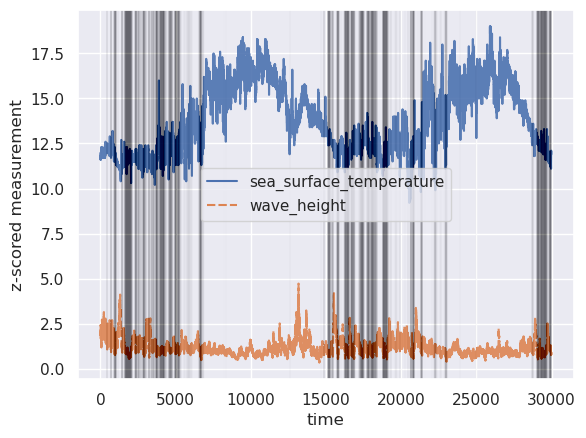

In [3]:
# Point Santa Cruz, CA (254)
ds = xr.open_dataset('https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/46269/46269.ncml')
ds = ds.sel(time=slice('2021-01-01','2023-03-05'))

# Get buoy data from NOAA
noaa_df = ds.to_dataframe().reset_index()
print(noaa_df.columns) 

# Get sea surface temps
_zscore = lambda S: (S - np.nanmean(S)) / np.nanstd(S)
cov = noaa_df[['sea_surface_temperature','wave_height']]
cov = cov.dropna().reset_index().drop(columns=['index'])

# Fit mixture model 
num_components = 10
dpgmm_model = mix.BayesianGaussianMixture(
    n_components=num_components, 
    weight_concentration_prior_type='dirichlet_process',
    n_init=10,
    max_iter=100)
p = dpgmm_model.fit_predict(cov)

# Visualize 
fig,ax = plt.subplots()

# Count States
state_counts = np.zeros(num_components)
for M in p:
  state_counts[M] += 1 
print(state_counts)

# Plot States
sns.lineplot(data=cov, ax=ax, alpha=0.9)
for M in range(len(p)): 
  if p[M] == p[-1]:
    ax.axvline(M, color='black', alpha=0.002) 
plt.ylabel('z-scored measurement')
plt.xlabel('time')
plt.show()